In [3]:
from google.colab import files
uploaded = files.upload()

Saving Train_Data.csv to Train_Data.csv


In [4]:
import pandas as pd
train = pd.read_csv('Train_Data.csv')
train.shape

(1966, 9)

In [5]:
from google.colab import files
uploaded = files.upload()

Saving Test_Data.csv to Test_Data.csv


In [6]:
pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [8]:
test = pd.read_csv('Test_Data.csv')
test.shape

(312, 8)

In [9]:
train.isnull().sum()

,0
SEQN,12
RIAGENDR,18
PAQ605,13
BMXBMI,18
LBXGLU,13
DIQ010,18
LBXGLT,11
LBXIN,9
age_group,14


In [10]:
print(train.columns)
print(train['age_group'].unique())

Index(['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
       'LBXIN', 'age_group'],
      dtype='object')
['Adult' 'Senior' nan]


In [11]:
print(test.columns)

Index(['SEQN', 'RIAGENDR', 'PAQ605', 'BMXBMI', 'LBXGLU', 'DIQ010', 'LBXGLT',
       'LBXIN'],
      dtype='object')


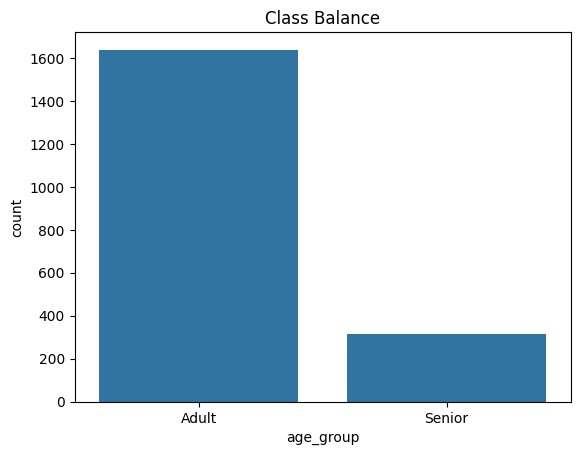

In [12]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.utils import resample
from sklearn.feature_selection import SelectFromModel
from catboost import CatBoostClassifier

sns.countplot(data=train, x='age_group')
plt.title("Class Balance")
plt.show()

In [13]:
print("Proportion of classes:")
print(train['age_group'].value_counts(normalize=True))

Proportion of classes:
age_group
Adult     0.839139
Senior    0.160861
Name: proportion, dtype: float64


In [14]:
train = train.dropna(subset=['age_group'])
train['age_group'] = train['age_group'].map({'Adult': 0, 'Senior': 1})

# Fill missing values with median
train.fillna(train.median(numeric_only=True), inplace=True)
test.fillna(test.median(numeric_only=True), inplace=True)

senior = train[train['age_group'] == 1]
adult = train[train['age_group'] == 0]
senior_upsampled = resample(senior, replace=True, n_samples=len(adult), random_state=42)
train_balanced = pd.concat([adult, senior_upsampled])

X_train = train_balanced.drop(columns=['SEQN', 'age_group'])
y_train = train_balanced['age_group']
X_test = test.drop(columns=['SEQN'])

In [15]:
X_train['bmi_glucose_ratio'] = X_train['BMXBMI'] / (X_train['LBXGLU'] + 1)
X_test['bmi_glucose_ratio'] = X_test['BMXBMI'] / (X_test['LBXGLU'] + 1)

X_train['has_diabetes'] = (X_train['DIQ010'] == 1).astype(int)
X_test['has_diabetes'] = (X_test['DIQ010'] == 1).astype(int)

X_train['glu_insulin_ratio'] = X_train['LBXGLU'] / (X_train['LBXIN'] + 1)
X_test['glu_insulin_ratio'] = X_test['LBXGLU'] / (X_test['LBXIN'] + 1)

X_train['active'] = (X_train['PAQ605'] == 1).astype(int)
X_test['active'] = (X_test['PAQ605'] == 1).astype(int)

X_train['insulin_glucose_ratio'] = X_train['LBXIN'] / (X_train['LBXGLU'] + 1)
X_test['insulin_glucose_ratio'] = X_test['LBXIN'] / (X_test['LBXGLU'] + 1)

X_train['activity_bmi'] = X_train['active'] * X_train['BMXBMI']
X_test['activity_bmi'] = X_test['active'] * X_test['BMXBMI']


In [16]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
rf_selector = RandomForestClassifier(n_estimators=100, random_state=42)
rf_selector.fit(X_train_scaled, y_train)
selector = SelectFromModel(rf_selector, threshold='median', prefit=True)
X_train_selected = selector.transform(X_train_scaled)
X_test_selected = selector.transform(X_test_scaled)

In [18]:
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss', scale_pos_weight=1.0)
lr = LogisticRegression(class_weight='balanced', max_iter=1000)
rf = RandomForestClassifier(n_estimators=150, max_depth=6, class_weight='balanced', random_state=42)
cat = CatBoostClassifier(verbose=0, random_state=42, iterations=300, depth=6, learning_rate=0.05)


In [19]:
stack_model = StackingClassifier(
    estimators=[
        ('xgb', xgb),
        ('lr', lr),
        ('rf', rf)
    ],
    final_estimator=cat,
    cv=5,
    passthrough=True
)
stack_model.fit(X_train_selected, y_train)

/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:18:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:18:58] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [17:19:00] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


StackingClassifier(cv=5,
                   estimators=[('xgb',
                                XGBClassifier(base_score=None, booster=None,
                                              callbacks=None,
                                              colsample_bylevel=None,
                                              colsample_bynode=None,
                                              colsample_bytree=None,
                                              device=None,
                                              early_stopping_rounds=None,
                                              enable_categorical=False,
                                              eval_metric='logloss',
                                              feature_types=None,
                                              feature_weights=None, gamma=None,
                                              grow_policy=None,
                                              importance_type=None,
                                              interac...
                                              monotone_constraints=None,
                                              multi_strategy=None,
                                              n_estimators=None, n_jobs=None,
                                              num_parallel_tree=None, ...)),
                               ('lr',
                                LogisticRegression(class_weight='balanced',
                                                   max_iter=1000)),
                               ('rf',
                                RandomForestClassifier(class_weight='balanced',
                                                       max_depth=6,
                                                       n_estimators=150,
                                                       random_state=42))],
                   final_estimator=<catboost.core.CatBoostClassifier object at 0x7cd4e372a120>,
                   passthrough=True)

In [20]:
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train_selected, y_train, test_size=0.2, stratify=y_train, random_state=42)
val_probs = stack_model.predict_proba(X_val_split)[:, 1]

In [21]:
thresholds = np.arange(0.1, 0.9, 0.01)
best_threshold = 0.5
best_f1 = 0
for t in thresholds:
    preds = (val_probs >= t).astype(int)
    score = f1_score(y_val_split, preds)
    if score > best_f1:
        best_f1 = score
        best_threshold = t
print(f"Best threshold: {best_threshold}")
print(f"Best F1-score: {best_f1}")

Best threshold: 0.20999999999999996
Best F1-score: 1.0


In [22]:

val_preds = (val_probs >= best_threshold).astype(int)
print(classification_report(y_val_split, val_preds))
print(confusion_matrix(y_val_split, val_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       328
           1       1.00      1.00      1.00       328

    accuracy                           1.00       656
   macro avg       1.00      1.00      1.00       656
weighted avg       1.00      1.00      1.00       656

[[328   0]
 [  0 328]]


In [23]:
test_probs = stack_model.predict_proba(X_test_selected)[:, 1]
test_preds = (test_probs >= best_threshold).astype(int)

In [24]:
submission = pd.DataFrame({'age_group': test_preds})
submission.to_csv("Vivan_FINAL_STACKED_submission.csv", index=False)
print(submission['age_group'].value_counts())


age_group
0    286
1     26
Name: count, dtype: int64


In [25]:
print(X_train.shape, X_test.shape)
print(y_train.value_counts())


(3276, 13) (312, 13)
age_group
0    1638
1    1638
Name: count, dtype: int64
